In [67]:
#####Latent Count Mixed membership Block model#####
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import numpy.matlib
import scipy.linalg
import itertools
from scipy import sparse
from scipy.stats import norm
from numpy.random import *
from scipy import optimize

In [68]:
#多項分布の乱数を生成する関数
def rmnom(pr, n, k, pattern):
    if pattern==1:
        z_id = np.array(np.argmax(np.cumsum(pr, axis=1) >= np.random.uniform(0, 1, n)[:, np.newaxis], axis=1), dtype="int")
        Z = np.diag(np.repeat(1, k))[z_id, ]
        return z_id, Z
    z_id = np.array(np.argmax((np.cumsum(pr, axis=1) >= np.random.uniform(0, 1, n)[:, np.newaxis]), axis=1), dtype="int")
    return z_id

#切断ポアソン分布の乱数を生成する関数
def rtpois(mu, a, b, n):
    if a==0:
        FA = np.exp(-mu)
    else:
        FA = scipy.stats.poisson.cdf(a, mu)
    if b==np.inf:
        FB = np.repeat(1.0, n)
    else:
        FB = scipy.stats.poisson.cdf(b, mu)
    return np.array(scipy.stats.poisson.ppf(np.random.uniform(0, 1, n)*(FB-FA)+FA, mu), dtype="int")

#ポアソン分布の対数尤度
def loglike(mu, y, y_factorial):
    LL = y * np.log(mu) - mu - y_factorial
    return LL

In [69]:
####学習データの生成####
##データの設定
#データの定義
g = 3   #グラフ数
k1 = 7; k2 = 6   #トピック数
d1 = 3000; d2 = 2500   #ノード数 
Lambda = np.random.gamma(30.0, 1/0.225, d1)
n = np.random.poisson(Lambda, d1)
N = np.sum(n)
k_vec1 = np.repeat(1.0, k1)
k_vec2 = np.repeat(1.0, k2)

#idを定義
d_id1 = np.repeat(np.arange(d1), n)
pt_id1 = np.array(list(itertools.chain(*[np.array(range(n[i]), dtype="int") for i in range(d1)])))
d_list1 = [i for i in range(d1)]
for i in range(d1):
    d_list1[i] = np.array(np.where(d_id1==i)[0], "int")

In [70]:
##ノードの割当を生成
#セグメント割当を生成
topic = 30
phi0 = np.random.dirichlet(np.repeat(1.0, d2), topic)
theta0 = np.random.dirichlet(np.repeat(0.25, topic), d1)
z = rmnom(theta0[d_id1, ], N, topic, 0)

#多項分布からアイテムを生成
d_id2 = np.zeros(N, dtype='int')
for i in range(d1):
    d_id2[d_list1[i]] = rmnom(phi0[z[d_list1[i]], ], n[i], d2, 0)

In [71]:
##パラメータを生成
#トピック分布を生成
theta1 = np.random.dirichlet(np.repeat(0.2, k1), d1)
theta2 = np.random.dirichlet(np.repeat(0.2, k2), d2)
thetat1 = theta1.copy(); thetat2 = theta2.copy()

#モデルパラメータを生成
phi = np.random.gamma(0.3, 10.0, k1*k2*g).reshape(k1, k2, g)
phit = phi.copy()

##応答変数を生成
#トピックを生成
z1, Z1 = rmnom(theta1[d_id1, ], N, k1,  1)
z2, Z2 = rmnom(theta2[d_id2, ], N, k2,  1)

#ポアソン分布からリンクを生成
mu = np.zeros((N, g))
freq = np.zeros((N, g), dtype="int")
for j in range(g):
    mu[:, j] = np.sum(phi[z1, :, j] * Z2, axis=1)
    freq[:, j] = np.random.poisson(mu[:, j], N)
y = np.array(freq > 0, dtype="int")
rate = np.mean(y, axis=0)

##データの再設定
#頻度が出現しないレコードを削除
y_index = np.array(np.where(np.sum(y, axis=1))[0], dtype="int")
y = y[y_index]
freq = freq[y_index]
mu = mu[y_index]
d_id1 = d_id1[y_index]
d_id2 = d_id2[y_index]
Z1 = Z1[y_index]
Z2 = Z2[y_index]
z1 = z1[y_index]
z2 = z2[y_index]
N = y_index.shape[0]

#インデックスを定義
y_list = [j for j in range(g)]
n1 = np.repeat(0, d1)
n2 = np.repeat(0, d2)
d_list1 = [i for i in range(d1)]
d_list2 = [i for i in range(d2)]
d_vec1 = [i for i in range(d1)]
d_vec2 = [i for i in range(d2)]
for j in range(g):
    y_list[j] = np.array(np.where(y[:, j]==1)[0], dtype="int")
for i in range(d1):
    d_list1[i] = np.array(np.where(d_id1==i)[0], "int")
    d_vec1[i] = np.repeat(1.0, d_list1[i].shape[0])
    n1[i] = d_list1[i].shape[0]
for i in range(d2):
    d_list2[i] = np.array(np.where(d_id2==i)[0], "int")
    d_vec2[i] = np.repeat(1.0, d_list2[i].shape[0])
    n2[i] = d_list2[i].shape[0]

In [72]:
####テストデータの生成####
##データの設定
#データの定義
n0 = np.random.poisson(Lambda, d1)
N0 = np.sum(n0)

#idを定義
d_id01 = np.repeat(np.arange(d1), n0)
pt_id01 = np.array(list(itertools.chain(*[np.array(range(n0[i]), dtype="int") for i in range(d1)])))
d_list01 = [i for i in range(d1)]
for i in range(d1):
    d_list01[i] = np.array(np.where(d_id01==i)[0], "int")
    
##ノードの割当を生成
#セグメント割当を生成
z = rmnom(theta0[d_id01, ], N0, topic, 0)

#多項分布からアイテムを生成
d_id02 = np.zeros(N0, dtype='int')
for i in range(d1):
    d_id02[d_list01[i]] = rmnom(phi0[z[d_list01[i]], ], n0[i], d2, 0)
    
    
##応答変数を生成
#トピックを生成
z01, Z01 = rmnom(theta1[d_id01, ], N0, k1, 1)
z02, Z02 = rmnom(theta2[d_id02, ], N0, k2, 1)

#ポアソン分布からリンクを生成
mu0 = np.zeros((N0, g))
freq0 = np.zeros((N0, g), dtype="int")
for j in range(g):
    mu0[:, j] = np.sum(phi[z01, :, j] * Z02, axis=1)
    freq0[:, j] = np.random.poisson(mu0[:, j], N0)
y0 = np.array(freq0 > 0, dtype="int")

#インデックスを定義
y_list0 = [j for j in range(g)]
for j in range(g):
    y_list0[j] = np.array(np.where(y0[:, j]==1)[0], dtype="int")
y_index0 = np.array(np.where(np.sum(y0, axis=1) > 0)[0], dtype="int")

In [73]:
####ギブスサンプリングでパラメータを推定####
##アルゴリズムの設定
R = 2000
keep = 2
burnin = int(1000/keep)
iter = 0
disp = 10

In [74]:
##事前分布の設定
alpha = 0.1
s0 = 0.5
v0 = 0.5

In [88]:
##パラメータの真値
#モデルパラメータの真値
theta1 = thetat1.copy()
theta2 = thetat2.copy()
phi = phit.copy()

#トピックの真値
Zi1 = Z1.copy()
Zi2 = Z2.copy()
z_vec1 = np.dot(Zi1, np.arange(k1))
z_vec2 = np.dot(Zi2, np.arange(k2))

In [92]:
##パラメータの初期値
#モデルパラメータの初期値
theta1 = np.random.dirichlet(np.repeat(1.0, k1), d1)
theta2 = np.random.dirichlet(np.repeat(1.0, k2), d2)
phi = np.random.gamma(1.0, 1.0, k1*k2*g).reshape(k1, k2, g)

##応答変数を生成
#トピックを生成
z_vec1, Zi1 = rmnom(theta1[d_id1, ], N, k1,  1)
z_vec2, Zi2 = rmnom(theta2[d_id2, ], N, k2,  1)

In [93]:
#対数尤度の基準値
mut = np.zeros((N, g))
LLbest = np.repeat(0.0, g)
for j in range(g):
    index = y_list[j]
    mut[:, j] = np.sum(phit[np.dot(Z1, np.arange(k1)), :, j] * Z2, axis=1)
    LLbest[j] = np.sum(scipy.stats.poisson.logpmf(freq[index, j], mut[index, j]))

In [94]:
####パラメータをサンプリング####
for rp in range(R):
    
    ##潜在的頻度を生成
    #ベルヌーイ分布から潜在リンクを生成
    mu = np.zeros((N, g))
    for j in range(g):
        index = y_list[j]
        mu[:, j] = np.sum(phi[z_vec1, :, j] * Zi2, axis=1)
    Prob = 1 - np.exp(-mu)
    Si = y * np.random.binomial(1, Prob)

    #切断ポアソン分布から潜在頻度を生成
    x = np.zeros((N, g), dtype="int")
    x_list = [j for j in range(g)]
    graph_list1 = [j for j in range(g)]
    graph_list2 = [j for j in range(g)]
    s_index = [j for j in range(g)]
    for j in range(g):
        index = y_list[j]
        x[index, j] = Si[index, j] * rtpois(mu[index, j], 0, np.inf, index.shape[0])
        #x[index, j] = Si[index, j] * np.random.poisson(mu[index, j], index.shape[0])
        x_list[j] = x[index, j][:, np.newaxis]
        graph_list1[j] = d_id1[index]
        graph_list2[j] = d_id2[index]

        
    ##始点ノードのトピックをサンプリング
    #終点ノードのトピックを周辺化した事後分布を定義
    Lho = np.zeros((N, k1))
    for i in range(k1):
        Li = np.full((N, g), 1.0)
        for j in range(g):
            index = y_list[j]
            Li[index, j] = np.dot(theta2[graph_list2[j], ] * scipy.stats.poisson.pmf(x_list[j], phi[i, :, j]), k_vec2)
        Lho[:, i] = np.prod(Li, axis=1)
    Posterior = theta1[d_id1, ] * Lho

    #多項分布からトピックをサンプリング
    Prob = Posterior / np.dot(Posterior, k_vec1)[:, np.newaxis]
    z_vec1, Zi1 = rmnom(Prob, N, k1, 1)
    
    
    ##終点ノードのトピックをサンプリング
    #始点ノードのトピックを周辺化した事後分布を定義
    Lho = np.zeros((N, k2))
    for i in range(k2):
        Li = np.full((N, g), 1.0)
        for j in range(g):
            index = y_list[j]
            Li[index, j] = np.dot(theta1[graph_list1[j], ] * scipy.stats.poisson.pmf(x_list[j], phi[:, i, j]), k_vec1)
        Lho[:, i] = np.prod(Li, axis=1)
    Posterior = theta2[d_id2, ] * Lho

    #多項分布からトピックをサンプリング
    Prob = Posterior / np.dot(Posterior, k_vec2)[:, np.newaxis]
    z_vec2, Zi2 = rmnom(Prob, N, k2, 1)
    
    
    ##トピック分布をサンプリング
    #始点ノードのトピック分布をサンプリング
    wsum1 = np.zeros((d1, k1))
    for i in range(d1):
        wsum1[i, ] = np.dot(Zi1[d_list1[i], ].T, d_vec1[i]) + alpha
        theta1[i, ] = np.random.dirichlet(wsum1[i, ], 1)

    #終点ノードのトピック分布をサンプリング
    wsum2 = np.zeros((d2, k2))
    for i in range(d2):
        wsum2[i, ] = np.dot(Zi2[d_list2[i], ].T, d_vec2[i]) + alpha
        theta2[i, ] = np.random.dirichlet(wsum2[i, ], 1)


    ##モデルパラメータをサンプリング
    for j in range(g):
        #ガンマ分布のパラメータ
        index = y_list[j]
        s = np.dot((Zi1[index, ] * x[index, j][:, np.newaxis]).T, Zi2[index, ]) + s0
        v = np.dot(Zi1[index, ].T, Zi2[index, ]) + v0

        #パラメータをサンプリング
        phi[:, :, j] = np.random.gamma(s, 1/v)
        
     
    ##サンプリング結果の格納と表示
    #対数尤度を更新
    if rp%disp==0:
        LLst = np.sum(scipy.stats.poisson.logpmf(x, np.mean(x, axis=0)), axis=0)
        mu = np.zeros((N, g))
        LL = np.repeat(0.0, g)
        for j in range(g):
            index = y_list[j]
            mu[:, j] = np.sum(phi[z_vec1, :, j] * Zi2, axis=1)
            LL[j] = np.sum(scipy.stats.poisson.logpmf(freq[index, j], mu[index, j]))

        print(rp)
        print(np.round([np.append(LL, np.sum(LL)), np.append(LLbest, np.sum(LLbest))], 1))

0
[[-1841486.8 -3272926.4 -2830239.2 -7944652.4]
 [ -444599.8  -516577.7  -484832.3 -1446009.8]]
10
[[-1751337.7 -3149144.1 -2698956.3 -7599438. ]
 [ -444599.8  -516577.7  -484832.3 -1446009.8]]
20
[[-1728627.  -3136256.9 -2676397.4 -7541281.3]
 [ -444599.8  -516577.7  -484832.3 -1446009.8]]
30
[[-1726179.4 -3113893.4 -2642940.  -7483012.7]
 [ -444599.8  -516577.7  -484832.3 -1446009.8]]
40
[[-1710616.9 -3135751.6 -2642804.6 -7489173. ]
 [ -444599.8  -516577.7  -484832.3 -1446009.8]]
50
[[-1710533.5 -3137424.9 -2637951.5 -7485909.9]
 [ -444599.8  -516577.7  -484832.3 -1446009.8]]
60
[[-1714129.3 -3116849.6 -2635781.5 -7466760.4]
 [ -444599.8  -516577.7  -484832.3 -1446009.8]]
70
[[-1719664.  -3137536.2 -2611020.8 -7468221.1]
 [ -444599.8  -516577.7  -484832.3 -1446009.8]]
80
[[-1719909.5 -3122603.  -2603845.3 -7446357.8]
 [ -444599.8  -516577.7  -484832.3 -1446009.8]]
90
[[-1723192.5 -3153582.6 -2583888.1 -7460663.2]
 [ -444599.8  -516577.7  -484832.3 -1446009.8]]
100
[[-1725065.6 -316

KeyboardInterrupt: 

In [100]:
np.log10(100)

np.power(10, 2)

100

In [120]:
300.7/60/60 * 1000

83.52777777777779

(array([ 20.,  77., 165., 250., 244., 146.,  70.,  20.,   6.,   2.]),
 array([1949.43746719, 1962.58168699, 1975.7259068 , 1988.8701266 ,
        2002.0143464 , 2015.15856621, 2028.30278601, 2041.44700581,
        2054.59122561, 2067.73544542, 2080.87966522]),
 <a list of 10 Patch objects>)

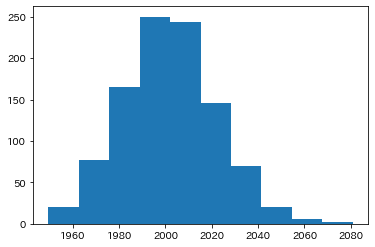

In [66]:
plt.hist(np.random.gamma(10000.0, 0.2, 1000))

(array([37138.,  2869.,  3345.,     0.,     0.,  3017.,  2462.,  7944.,
         2754., 54734.]),
 array([3.23790794e-09, 9.99999970e-02, 1.99999991e-01, 2.99999985e-01,
        3.99999978e-01, 4.99999972e-01, 5.99999966e-01, 6.99999960e-01,
        7.99999953e-01, 8.99999947e-01, 9.99999941e-01]),
 <a list of 10 Patch objects>)

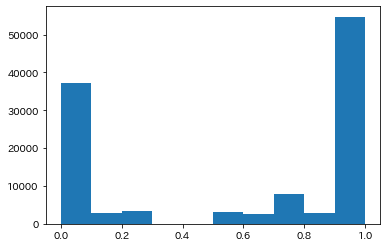

In [54]:
plt.hist(1 - np.exp(-mut[:, 0]))

In [55]:
pd.DataFrame(np.round(phit[:, :, 0] , 3))

,0,1,2,3,4,5
0,10.111,0.001,16.647,9.424,0.000,0.000
1,4.424,2.930,8.120,6.106,0.308,5.202
2,0.302,1.248,0.001,6.853,0.000,0.134
3,0.006,0.706,2.635,0.086,0.088,0.052
4,0.003,0.019,0.024,3.732,2.553,0.000
5,1.854,1.354,11.899,0.001,2.946,0.064
6,1.303,5.714,8.290,6.167,0.947,4.085


In [56]:
pd.DataFrame(np.round(phi[:, :, 0] , 3))

,0,1,2,3,4,5
0,4.757,5.505,4.857,5.823,5.188,3.486
1,5.082,5.817,5.040,6.013,5.036,3.747
2,4.413,4.953,4.444,5.348,4.503,3.241
3,3.695,4.282,3.961,4.633,3.693,2.937
4,5.071,5.370,5.021,5.892,5.043,3.506
5,4.449,5.010,4.669,5.616,4.650,3.414
6,4.593,5.360,4.921,5.640,5.034,3.686


In [ ]:
j = 0
s = np.dot((Zi1[index, ] * freq[index, j][:, np.newaxis]).T, Zi2[index, ]) + s0
v = np.dot(Zi1[index, ].T, Zi2[index, ]) + v0

#パラメータをサンプリング
np.round(pd.DataFrame(np.random.gamma(s, 1/v)), 3)

In [ ]:
pd.DataFrame(np.round(phit[:, :, 0] , 3))